# Information Retrieval

For this type of system we will carry out the same experimentation using no context and different generation models, GPT-3.5-turbo, GPT-4, GPT-4o and GPT-4-mini.

To measure the quality of the system, we will use the defined metric TPPI.

## 0. Set up

In [1]:
# Switch to home project directory
%cd ../..

/Users/alejandro.medrano/Projects/UNITE_TALKING_POINTS


/Users/alejandro.medrano/.local/share/virtualenvs/UNITE_TALKING_POINTS-QWuKLflF/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import json
import os

import pandas as pd
import numpy as np

import spacy

import seaborn as sns
import matplotlib.pyplot as plt

from bert_score import BERTScorer
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import logging
logging.set_verbosity_error()

from tqdm.notebook import tqdm

from textstat import flesch_reading_ease

from src.unite_talking_points.utils.config.config_loader import ConfigLoader
from typing import TypedDict
import openai

In [3]:
config = ConfigLoader().load_config(current_directory_is_root=True)
os.environ["OPENAI_API_KEY"] = config['External-services']['openai_api_key']
client = openai.OpenAI(api_key=config['External-services']['openai_api_key'])

In [4]:
class TPPIResult(TypedDict):
    TPPI: float
    BertScore: float
    Normalized_BertScore: float
    Perplexity: float
    Normalized_Perplexity: float
    Flesch: float
    Normalized_Flesch: float


class TPPI:
    def __init__(self, model_type: str = 'bert-base-uncased'):
        """
        Inicializa el normalizador de puntuaciones y los modelos necesarios para los cálculos.
        """
        self.scorer = BERTScorer(model_type=model_type)
        self.gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

        # Set the maximum lenght for GPT-2
        self.perplexity_max_length = 1024

    @staticmethod
    def normalize_bert_score(bert_score: float) -> float:
        """
        Normaliza el puntaje BERT en un rango de 0 a 1.
        """
        return (bert_score + 1) / 2

    @staticmethod
    def normalize_perplexity(perplexity: float) -> float:
        """
        Normaliza el valor de la perplejidad en un rango de 0 a 1.
        """
        # Aseguramos que la perplexidad mínima sea al menos 1 para evitar división por cero
        perplexity = max(perplexity, 1)
        # Invertimos la fórmula para que valores bajos de perplexidad den valores altos normalizados
        return 1 - (min(perplexity, 100) - 1) / 99

    @staticmethod
    def normalize_flesch(flesch: float) -> float:
        """
        Normaliza el puntaje de Flesch en un rango de 0 a 1.
        """
        return max(min(flesch, 100), 0) / 100

    def calculate_bert_score(self, reference_text: str, generated_text: str) -> float:
        """
        Calcula el BertScore entre un texto de referencia y uno generado.
        """
        P, R, F1 = self.scorer.score([reference_text], [generated_text], verbose=False)
        bert_score = F1.item()
        return bert_score

    def calculate_perplexity(self, text: str) -> float:
        """
        Calcula la perplejidad de un texto utilizando el modelo GPT-2.
        """
        # Tokenize the input text
        encode = self.gpt2_tokenizer.encode(text, return_tensors='pt')
    
        # Trim the input if it exceeds the maximum length
        if encode.size(1) > self.perplexity_max_length:  # Check the token sequence length
            encode = encode[:, :self.perplexity_max_length]  # Trim to the first max_length tokens
    
        # Calculate the perplexity
        with torch.no_grad():
            loss = self.gpt2_model(encode, labels=encode)[0]
        perplexity = torch.exp(loss).item()
        
        return perplexity

    @staticmethod
    def calculate_flesch(text: str) -> float:
        """
        Calcula el puntaje de Flesch Reading Ease de un texto.
        """
        flesch_score = flesch_reading_ease(text)
        return flesch_score

    def calculate_tppi(self, original_text: str, generated_text: str) -> TPPIResult:
        """
        Calcula el TPPI basado en los textos de referencia y generados, devolviendo los puntajes de BERT,
        perplejidad y Flesch tanto normalizados como sin normalizar.
        """
        # Calcula BertScore
        bert_score = self.calculate_bert_score(original_text, generated_text)
        normalized_bert_score = self.normalize_bert_score(bert_score)

        # Calcula Perplejidad
        perplexity = self.calculate_perplexity(generated_text)
        normalized_perplexity = self.normalize_perplexity(perplexity)

        # Calcula Flesch
        flesch = self.calculate_flesch(generated_text)
        normalized_flesch = self.normalize_flesch(flesch)

        # Calcula TPPI
        tppi_score = 0.5 * normalized_bert_score + 0.25 * normalized_perplexity + 0.25 * normalized_flesch

        # Devuelve todos los valores en un TypedDict
        return TPPIResult(
            TPPI=tppi_score,
            BertScore=bert_score,
            Normalized_BertScore=normalized_bert_score,
            Perplexity=perplexity,
            Normalized_Perplexity=normalized_perplexity,
            Flesch=flesch,
            Normalized_Flesch=normalized_flesch
        )


## 1. Data loading

In [5]:
def load_json_data(data_dir):
    """
    Load JSON data from the specified directory into a pandas DataFrame.

    Args:
    - data_dir (str): Path to the directory containing JSON files.

    Returns:
    - df (pd.DataFrame): DataFrame containing the loaded JSON data.
    """
    # Initialize empty lists to store data
    file_names = []
    labels = []
    document_names = []
    meeting_names = []
    meeting_dates = []
    contents = []
    prompts = []

    # Iterate over each JSON file in the directory
    for filename in os.listdir(data_dir):
        if filename.endswith('.json'):
            with open(os.path.join(data_dir, filename), 'r') as file:
                data = json.load(file)
                # Extract data from each JSON file and append to lists
                file_names.append(filename)
                labels.append(data['label'])
                document_names.append(data['document_name'])
                meeting_names.append(data['meeting_name'])
                meeting_dates.append(data['meeting_date'])
                contents.append(data['content'])
                prompts.append(data['prompt'])

    # Create a DataFrame from the lists
    df = pd.DataFrame({
        'file_name': file_names,
        'label': labels,
        'document_name': document_names,
        'meeting_name': meeting_names,
        'meeting_date': meeting_dates,
        'content': contents,
        'prompt': prompts
    })

    return df

In [6]:
df = load_json_data(config['Directories']['raw_data_path'])

## 2. Experimentation

### 2.1 Model

In [7]:
def generate_talking_point(prompt, model="gpt-4o-mini"):
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )
    answer = response.choices[0].message.content
    return answer

In [8]:
# Initialize TPPI scoring system
tppi = TPPI()

# Function to conduct n experiments without averaging results
def conduct_experiment(df, model="gpt-4o-mini", n=3):
    results = []

    for i in tqdm(range(len(df))):
        
        prompt = df.iloc[i].prompt
        content = df['content'][i]
        file_name = df['file_name'][i]

        # Conduct n experiments
        for experiment_num in range(n):
            # Generate talking point
            generated_talking_point = generate_talking_point(prompt, model=model)

            # Calculate TPPI
            tppi_result = tppi.calculate_tppi(content, generated_talking_point)
            
            # Add metadata fields to each experiment result
            tppi_result['file_name'] = file_name
            tppi_result['model'] = model
            tppi_result['experiment_number'] = experiment_num + 1

            results.append(tppi_result)

    return results

/Users/alejandro.medrano/.local/share/virtualenvs/UNITE_TALKING_POINTS-QWuKLflF/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
# Run experiments
models = ['gpt-3.5-turbo', 'gpt-4o-mini', 'gpt-4o']
all_results = []

for model in models:
    all_results.append(conduct_experiment(df, model, 3))

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [14]:
flattened_data = [item for sublist in all_results for item in sublist]
all_results = pd.DataFrame(flattened_data)

In [15]:
# Calcula estadísticas básicas para cada método
statistics = all_results.groupby('model').agg({
    'TPPI': ['mean', 'std', 'min', 'max'],
    'BertScore': ['mean'],
    'Perplexity': ['mean'],
    'Flesch' : ['mean']
}).reset_index()

print(statistics)

           model      TPPI                               BertScore Perplexity  \
                      mean       std       min       max      mean       mean   
0  gpt-3.5-turbo  0.643886  0.024147  0.600077  0.707149  0.650055  15.805428   
1         gpt-4o  0.639814  0.029209  0.570272  0.711994  0.620973  17.497585   
2    gpt-4o-mini  0.634813  0.027354  0.570354  0.701507  0.619329  18.542607   

     Flesch  
       mean  
0  5.575000  
1  9.893889  
2  9.339444  


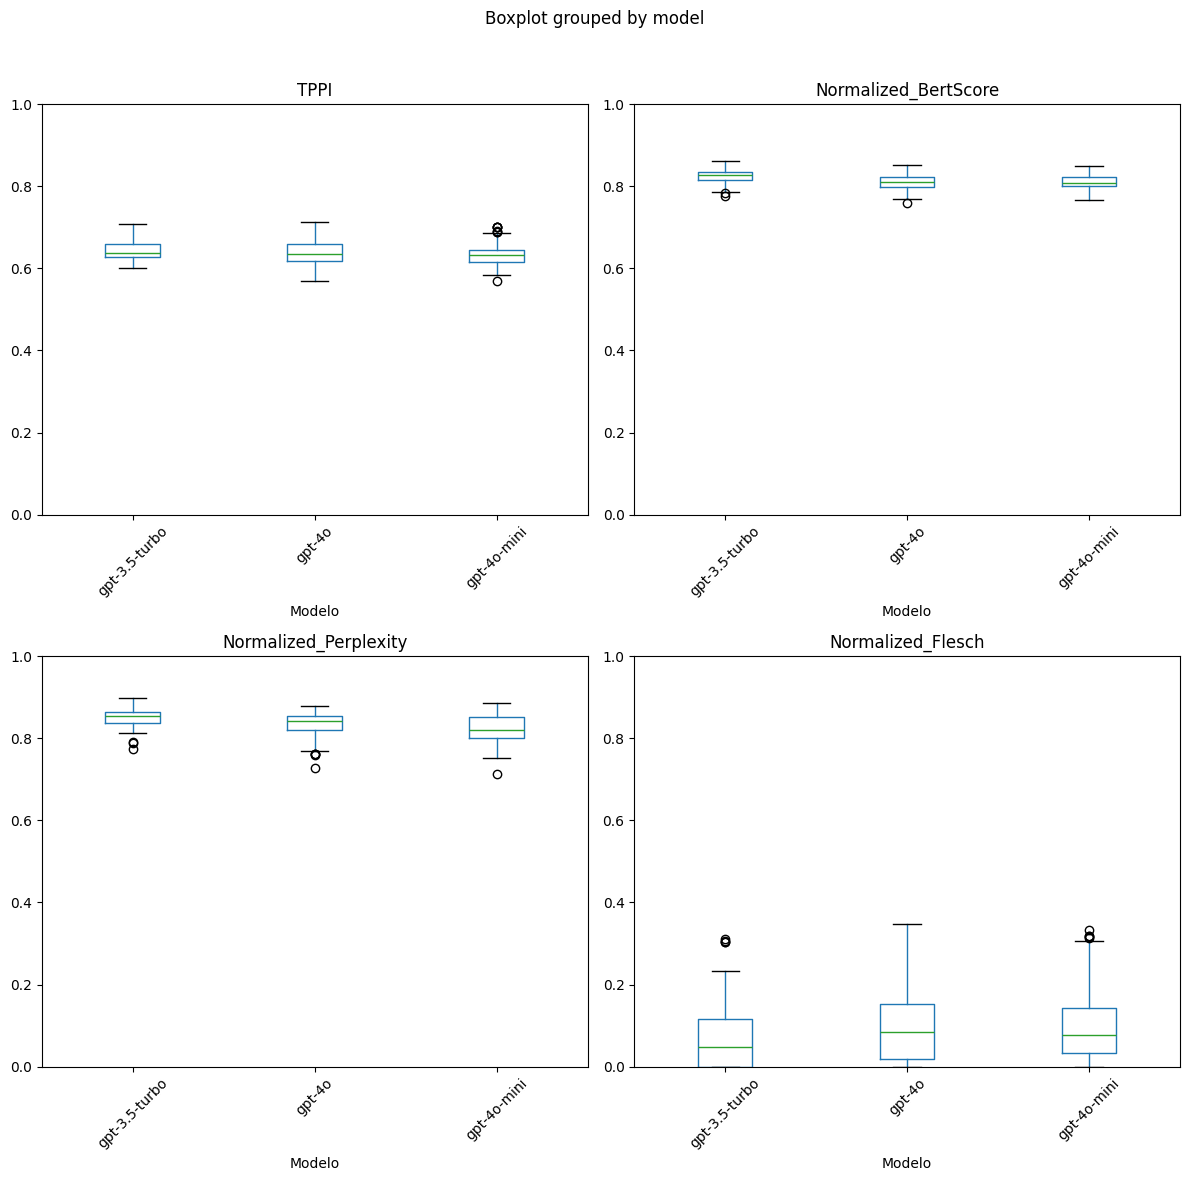

In [16]:
# Definir los nombres de las métricas para iterar
metrics = ['TPPI', 'Normalized_BertScore', 'Normalized_Perplexity', 'Normalized_Flesch']

# Crear un subplot 2x2 para los boxplots de cada métrica
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
fig.suptitle('Distribución de Métricas por Método de Vectorización', fontsize=16)

# Iterar sobre las métricas y los ejes para crear los boxplots
for ax, metric in zip(axes.flatten(), metrics):
    all_results.boxplot(column=metric, by='model', ax=ax, grid=False)
    ax.set_title(metric)
    ax.set_xlabel('Modelo')
    ax.set_ylim(0, 1)  # Asegurar que el gráfico esté limitado entre 0 y 1
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotar las etiquetas para mejor legibilidad

# Ajustar el layout para evitar la superposición de los títulos y etiquetas
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajusta los límites del rectángulo del layout
plt.show()

### 2.2 Temperature

In [25]:
def generate_talking_point(prompt, model="gpt-4o-mini", temperature=1.0):
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        temperature=temperature
    )
    answer = response.choices[0].message.content
    return answer


def conduct_experiment(df, model="gpt-4o-mini", temperatures=[0, 0.5, 1.0, 1.5, 2], n=3):
    results = []

    for i in tqdm(range(len(df))):
        prompt = df.iloc[i].prompt
        content = df['content'][i]
        file_name = df['file_name'][i]

        # Iterate over each temperature value
        for temp in tqdm(temperatures, leave=False):
            # Conduct n experiments for each temperature
            for experiment_num in tqdm(range(n), leave=False):
                # Generate talking point with specific temperature
                generated_talking_point = generate_talking_point(prompt, model=model, temperature=temp)

                # Calculate TPPI
                tppi_result = tppi.calculate_tppi(content, generated_talking_point)

                # Add metadata fields to each experiment result
                tppi_result['file_name'] = file_name
                tppi_result['temperature'] = temp
                tppi_result['experiment_number'] = experiment_num + 1

                results.append(tppi_result)

    return results

In [26]:
all_results = conduct_experiment(df, model="gpt-3.5-turbo", temperatures=[0, 0.5, 1.0, 1.5, 2], n=3)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [29]:
all_results = pd.DataFrame(all_results)

In [30]:
# Calcula estadísticas básicas para cada método
statistics = all_results.groupby('temperature').agg({
    'TPPI': ['mean', 'std', 'min', 'max'],
    'BertScore': ['mean'],
    'Perplexity': ['mean'],
    'Flesch' : ['mean']
}).reset_index()

print(statistics)

  temperature      TPPI                               BertScore   Perplexity  \
                   mean       std       min       max      mean         mean   
0         0.0  0.655290  0.025071  0.615602  0.728743  0.657156    14.044785   
1         0.5  0.652003  0.024678  0.613041  0.708504  0.656218    14.669818   
2         1.0  0.647052  0.024579  0.603789  0.712351  0.656750    15.881649   
3         1.5  0.509663  0.116847  0.351332  0.675729  0.606699   598.364887   
4         2.0  0.348730  0.007713  0.335366  0.373678  0.394922  3382.978945   

       Flesch  
         mean  
0    7.837333  
1    7.518000  
2    6.192778  
3  -87.873111  
4 -164.604111  


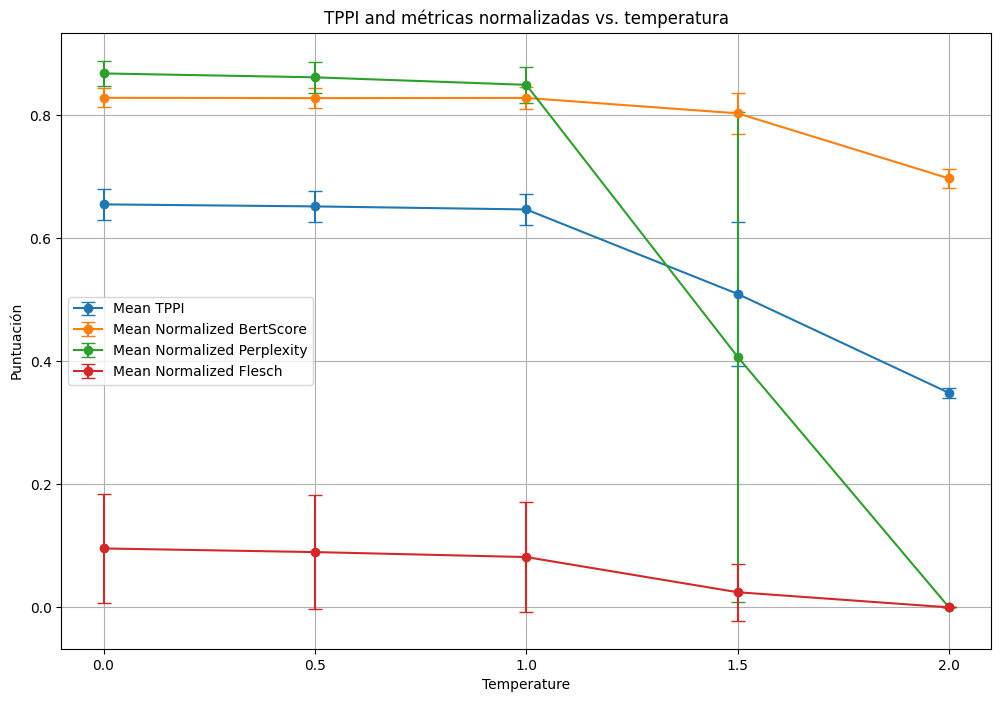

In [35]:
# Calculating mean values for each 'n'
mean_values = all_results[['TPPI', 'Normalized_BertScore', 'Normalized_Perplexity', 'Normalized_Flesch', 'temperature']].groupby('temperature').mean().reset_index()
# Generating error bars (standard deviation as an example)
std_values = all_results[['TPPI', 'Normalized_BertScore', 'Normalized_Perplexity', 'Normalized_Flesch', 'temperature']].groupby('temperature').std().reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.errorbar(mean_values['temperature'], mean_values['TPPI'], yerr=std_values['TPPI'], marker='o', label='Mean TPPI', capsize=5)
plt.errorbar(mean_values['temperature'], mean_values['Normalized_BertScore'], yerr=std_values['Normalized_BertScore'], marker='o', label='Mean Normalized BertScore', capsize=5)
plt.errorbar(mean_values['temperature'], mean_values['Normalized_Perplexity'], yerr=std_values['Normalized_Perplexity'], marker='o', label='Mean Normalized Perplexity', capsize=5)
plt.errorbar(mean_values['temperature'], mean_values['Normalized_Flesch'], yerr=std_values['Normalized_Flesch'], marker='o', label='Mean Normalized Flesch', capsize=5)

plt.title('TPPI and métricas normalizadas vs. temperatura')
plt.xlabel('Temperature')
plt.ylabel('Puntuación')
plt.xticks(mean_values['temperature'])  # Ensure x-axis labels match the temperature values
plt.legend()
plt.grid(True)
plt.show()